In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


input_path = "/home/rtlink/jiwon/paper_ws/src/bumpypatch/static scene/output_clusters"
output_path = os.path.join(input_path, "gabor_filtered")
filters_path = os.path.join(output_path, "filters")

Saved image_21.png to cluster 0 with 7 stripes
Saved image_33.png to cluster 2 with 4 stripes
Saved image_67.png to cluster 1 with 3 stripes
Saved image_83.png to cluster 1 with 3 stripes
Saved image_48.png to cluster 1 with 1 stripes
Saved image_8.png to cluster 2 with 6 stripes
Saved image_26.png to cluster 2 with 5 stripes
Saved image_56.png to cluster 1 with 1 stripes
Saved image_0.png to cluster 1 with 1 stripes
Saved image_84.png to cluster 1 with 3 stripes
Saved image_79.png to cluster 0 with 8 stripes
Saved image_53.png to cluster 2 with 5 stripes
Saved image_46.png to cluster 2 with 4 stripes
Saved image_35.png to cluster 1 with 1 stripes
Saved image_23.png to cluster 2 with 4 stripes
Saved image_22.png to cluster 2 with 5 stripes
Saved image_88.png to cluster 1 with 2 stripes
Saved image_5.png to cluster 1 with 2 stripes
Saved image_19.png to cluster 1 with 2 stripes
Saved image_32.png to cluster 2 with 6 stripes
Saved image_1.png to cluster 2 with 4 stripes
Saved image_34.pn

/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


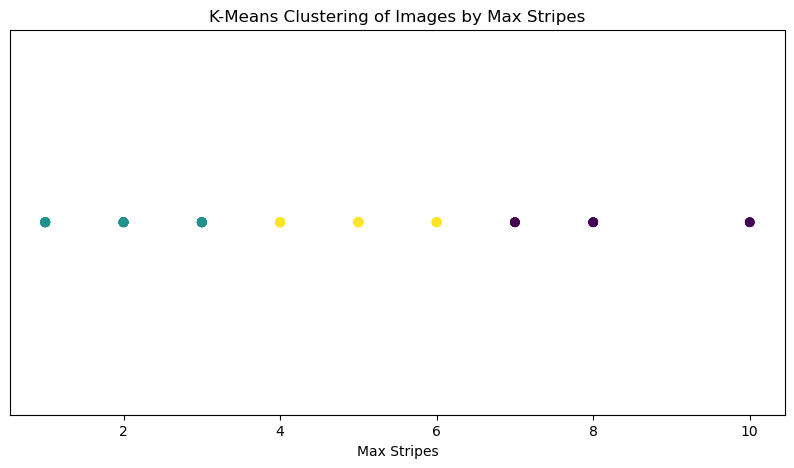

In [25]:
# 출력 폴더 생성
if not os.path.exists(output_path):
    os.mkdir(output_path)
if not os.path.exists(filters_path):
    os.mkdir(filters_path)

def apply_gabor_filter(image, angle):
    ksize = 15
    sigma = 3
    lambd = 3
    gamma = 0.5
    psi = 0  # phase offset
    theta = angle * np.pi / 16

    gabor_filter = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
    
    # 가버 필터 자체를 이미지로 저장
    filter_image = ((gabor_filter + 1) * 127.5).astype(np.uint8)
    filter_filename = os.path.join(filters_path, f"filter_angle_{angle}.png")
    cv2.imwrite(filter_filename, filter_image)

    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)

    # 임계값 설정 및 스트라이프 영역 검출
    threshold = np.max(filtered_image) * 0.9
    stripe_regions = filtered_image > threshold
    stripe_image = np.uint8(stripe_regions * 255)

    return stripe_image
    # return filtered_image

def visualize_samples(original, filtered, filename):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original: {filename}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(filtered, cmap='gray')
    plt.title("Filtered")
    
    plt.show()

def count_stripes(image, min_length=4): # 임계값을 인자로 추가
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    count = 0
    for contour in contours:
        length = cv2.arcLength(contour, True) # 외곽선의 길이 계산
        if length > min_length: # 길이가 임계값보다 크면 카운트
            count += 1
    return count

sample_count = 0

def save_images(original, filtered_images, filename, output_path):
    output_folder = os.path.join(output_path, filename[:-4]) # 확장자 제거
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    original_filename = os.path.join(output_folder, f"original.png")
    cv2.imwrite(original_filename, original)
    
    for angle, filtered_image in filtered_images.items():
        filtered_filename = os.path.join(output_folder, f"filtered_angle_{angle*45}.png")
        cv2.imwrite(filtered_filename, filtered_image)

images_to_cluster = []
labels = []
max_stripes_list = []  # 각 이미지의 max_stripes 값을 저장

# 이후 메인 코드에서 사용됩니다.
for filename in os.listdir(input_path):
    if filename.endswith(".png"):
    # if filename.endswith(".png") and sample_count < 10:
        file_path = os.path.join(input_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        max_stripes = 0
        best_image = None

        filtered_images = {} # 여기에 필터링된 이미지를 저장합니다.
        stripe_counts = []

        # plt.figure(figsize=(15, 10))
        # plt.subplot(3, 3, 1)
        # plt.imshow(image, cmap='gray')
        # plt.title("Original")

        for angle in range(8):
            filtered_image = apply_gabor_filter(image, angle)
            num_stripes = count_stripes(filtered_image)


            # 스트라이프 개수가 이전 최대값보다 큰 경우에만 best_image를 업데이트합니다.
            if num_stripes > max_stripes:
                max_stripes = num_stripes
                best_image = filtered_image

        # best_image가 None인 경우 처리
        if best_image is not None:
            images_to_cluster.append(best_image.flatten())
            labels.append(filename)
            max_stripes_list.append(max_stripes)

        #     stripe_counts.append(num_stripes)

        #     filtered_images[angle] = filtered_image # 필터링된 이미지를 추가합니다.

        #     plt.subplot(3, 3, angle + 2)
        #     plt.imshow(filtered_image, cmap='gray')
        #     plt.title(f"Angle: {angle*45} degrees, Stripes: {num_stripes}")

        # plt.show()

#         # 원본 이미지와 필터링된 이미지를 저장합니다.
#         save_images(image, filtered_images, filename, output_path)

#         print(f"File: {filename}, Stripe counts per angle: {stripe_counts}")

#         sample_count += 1

#         print(f"Applied Gabor filter to {filename} with 8 different angles and saved to folder.")

# print("All images processed.")


# k-means 클러스터링
n_clusters = 3 # 클러스터 수를 설정
# kmeans = KMeans(n_clusters=n_clusters).fit(images_to_cluster)
kmeans = KMeans(n_clusters=n_clusters).fit(np.array(max_stripes_list).reshape(-1, 1))

# 클러스터링 결과 폴더 생성
for i in range(n_clusters):
    cluster_path = os.path.join(output_path, f"cluster_{i}")
    if not os.path.exists(cluster_path):
        os.mkdir(cluster_path)

# 클러스터별로 이미지 저장
for idx, label in enumerate(labels):
    cluster_label = kmeans.labels_[idx]
    max_stripes = max_stripes_list[idx]
    file_path = os.path.join(input_path, label)
    original_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    max_stripes = max_stripes_list[idx]  # max_stripes 값을 가져옴

    best_image = images_to_cluster[idx].reshape(original_image.shape)

    # 원본 이미지와 스트라이프 이미지를 옆으로 붙입니다.
    combined_image = np.hstack((original_image, best_image))

    cluster_path = os.path.join(output_path, f"cluster_{cluster_label}")
    save_path = os.path.join(cluster_path, f"{label[:-4]}_stripes_{max_stripes}.png")  # 파일 이름에 max_stripes 추가

    cv2.imwrite(save_path, combined_image)
    print(f"Saved {label} to cluster {cluster_label} with {max_stripes} stripes")


# # PCA로 차원 축소 후 시각화
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(images_to_cluster)

# plt.figure(figsize=(10, 8))

# for i in range(n_clusters):
#     cluster_data = reduced_data[kmeans.labels_ == i]
#     plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')

# plt.legend()
# plt.title('K-Means Clustering of Images with Gabor Filter')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()
# 클러스터 레이블에 따라 산포도 그리기
plt.figure(figsize=(10, 5))
plt.scatter(max_stripes_list, [0] * len(max_stripes_list), c=kmeans.labels_)
plt.title('K-Means Clustering of Images by Max Stripes')
plt.xlabel('Max Stripes')
plt.yticks([])
plt.show()


In [42]:
def detect_stripes(image, angle, threshold=100):
    # 가버 필터 적용
    filtered_image = apply_gabor_filter(image, angle)

    # 엣지 검출을 위한 캐니 엣지 디텍터 적용
    edges = cv2.Canny(filtered_image, 50, 150)

    # 허프 라인 변환을 통한 선분 검출
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)

    return len(lines) if lines is not None else 0